# Compare GT and Rendered Image patchwise and compare frequency domain

In [2]:
import os
import numpy as np
import cv2
from glob import glob
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt

DATASET_SOURCE_PATH = "/home/hjp/KUAICV/NIPS2024_LOCAL/datasets/tandt/train/"

IMG_PATH_LSIT = glob(os.path.join(DATASET_SOURCE_PATH, "images", "*.jpg"))

In [3]:
# load scene, dataset

from glob import glob
import math
import torch
from scene import Scene
import os
import sys
import numpy as np
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from argparse import ArgumentParser, Namespace
from plyfile import PlyData, PlyElement

from utils.general_utils import safe_state
from utils.graphics_utils import getWorld2View2, getWorld2View, getProjectionMatrix
from arguments import ModelParams, PipelineParams, OptimizationParams, get_combined_args
from gaussian_renderer import GaussianModel

# Set up command line argument parser
parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")

args_cmdline = parser.parse_args(args=[
    "--model_path",
    #"/home/hjp/gaussian_models/bonsai",
    #"/home/hjp/gaussian-splatting/output/45f70d99-a",
    #"/home/hjp/gaussian-splatting/output/89274efe-d",
    #"/home/hjp/gaussian-splatting/output/e4d1418e-9",
    "/home/youngdong/gaussian_models/flowers",
    
    
    "--source_path",
    #"/home/hjp/dataset/mipnerf360/bonsai"
    #"/home/hjp/dataset/mipnerf360/garden",
    #"/home/hjp/dataset/tandt/train",
    "/home/hjp/dataset/flowers",
])

cfgfile_string = "Namespace()"
try:
    cfgfilepath = os.path.join(args_cmdline.model_path, "cfg_args")
    print("Looking for config file in", cfgfilepath)
    with open(cfgfilepath) as cfg_file:
        print("Config file found: {}".format(cfgfilepath))
        cfgfile_string = cfg_file.read()
except TypeError:
    print("Config file not found at")
    pass
print("Config file arguments: ", cfgfile_string)

args_cfgfile = eval(cfgfile_string)

merged_dict = vars(args_cfgfile).copy()
for k,v in vars(args_cmdline).items():
    if v != None:
        merged_dict[k] = v
args = Namespace(**merged_dict)

assert os.path.exists(args.model_path), "Model path does not exist"
assert os.path.exists(args.source_path), "Source path does not exist"

model_args = model.extract(args)
optim_args = op.extract(args)
pipe_args = pipeline.extract(args)

print(model_args.resolution)

Looking for config file in /home/youngdong/gaussian_models/flowers/cfg_args
Config file found: /home/youngdong/gaussian_models/flowers/cfg_args
Config file arguments:  Namespace(data_device='cuda', eval=True, images='images', model_path='/home/jang/models/flowers/', resolution=-1, sh_degree=3, source_path='/home/jang/dataset/flowers', white_background=False)
-1


In [4]:
model_args.data_device = "cuda"
gaussians = GaussianModel(model_args.sh_degree)
scene = Scene(
    model_args, gaussians, 
    load_iteration = args.iteration, shuffle = False
)

Loading trained model at iteration 30000
Reading camera 173/173
Loading Training Cameras
[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1
Loading Test Cameras


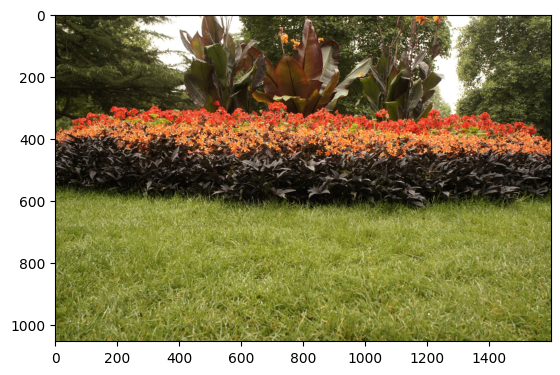

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


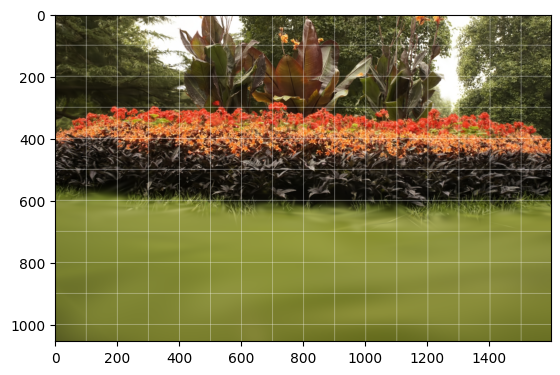

In [8]:
CAMERA_IDX = 10

train_camera_list = scene.getTrainCameras()

bg_color = [1, 1, 1] if model_args.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

image_gt_torch  = train_camera_list[CAMERA_IDX].original_image.detach().cpu()
image_gt_np     = (image_gt_torch.numpy().transpose(1,2,0) * 255).astype(np.uint8)
render_pkg  = render(
    train_camera_list[CAMERA_IDX], gaussians, pipe_args,
    bg_color = torch.rand((3), device="cuda") if optim_args.random_background else background
)
image_rendered_torch = render_pkg["render"].detach().cpu()
#image_rendered_np = (image_rendered_torch.numpy().transpose(1,2,0) * 255).astype(np.uint8)
image_rendered_np = image_rendered_torch.clamp(0, 1).permute(1,2,0).numpy()


plt.imshow(image_gt_np)
plt.show()

image_rendered_np[::100, :, :] = np.array([255, 255, 255], dtype=np.uint8)
image_rendered_np[:, ::100, :] = np.array([255, 255, 255], dtype=np.uint8)

plt.imshow(image_rendered_np)
plt.show()

In [ ]:
from utils.graphics_utils import getWorld2View2, getWorld2View, getProjectionMatrix


camera  = train_camera_list[CAMERA_IDX]

cam_center = np.linalg.inv(
    getWorld2View2(camera.R, camera.T)
)[:3, 3:4].copy().reshape(-1)

cam_basis_x = camera.R @ np.array([1,0,0])
cam_basis_y = camera.R @ np.array([0,1,0])
cam_basis_z = camera.R @ np.array([0,0,1])

lt_v = cam_basis_z - cam_basis_y * np.tan(camera.FoVy / 2) - cam_basis_x * np.tan(camera.FoVx / 2)
rt_v = cam_basis_z - cam_basis_y * np.tan(camera.FoVy / 2) + cam_basis_x * np.tan(camera.FoVx / 2)
lb_v = cam_basis_z + cam_basis_y * np.tan(camera.FoVy / 2) - cam_basis_x * np.tan(camera.FoVx / 2)
rb_v = cam_basis_z + cam_basis_y * np.tan(camera.FoVy / 2) + cam_basis_x * np.tan(camera.FoVx / 2)


image_height, image_width = image_gt_np.shape[:2]
patch_size = 100

ridx = 10
cidx = 10



p_lt_v = (patch_size * ridx / image_height) * (
    ((patch_size * cidx) / image_width) * rb_v + (image_width - patch_size * cidx) / image_width * lb_v
) + ((image_height - patch_size * ridx) / image_height) * (
    ((patch_size * cidx) / image_width) * rt_v + (image_width - patch_size * cidx) / image_width * lt_v
)
p_rt_v = (patch_size * ridx / image_height) * (
    ((patch_size * (cidx + 1)) / image_width) * rb_v + (image_width - patch_size * (cidx + 1)) / image_width * lb_v
) + ((image_height - patch_size * ridx) / image_height) * (
    ((patch_size * (cidx + 1)) / image_width) * rt_v + (image_width - patch_size * (cidx + 1)) / image_width * lt_v
)
p_lb_v = (patch_size * (ridx + 1) / image_height) * (
    ((patch_size * cidx) / image_width) * rb_v + (image_width - patch_size * cidx) / image_width * lb_v
) + ((image_height - patch_size * (ridx + 1)) / image_height) * (
    ((patch_size * cidx) / image_width) * rt_v + (image_width - patch_size * cidx) / image_width * lt_v
)
p_rb_v = (patch_size * (ridx + 1) / image_height) * (
    ((patch_size * (cidx + 1)) / image_width) * rb_v + (image_width - patch_size * (cidx + 1)) / image_width * lb_v
) + ((image_height - patch_size * (ridx + 1)) / image_height) * (
    ((patch_size * (cidx + 1)) / image_width) * rt_v + (image_width - patch_size * (cidx + 1)) / image_width * lt_v
)

In [1]:
import plotly.graph_objects as go

# Define vectors as [x, y, z]
vectors = [
    lt_v, rt_v, lb_v, rb_v,
    p_lt_v, p_rt_v, p_lb_v, p_rb_v
]

fig = go.Figure()

# Plot each vector
for vec in vectors:
    fig.add_trace(
        go.Scatter3d(
            x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]], 
            mode='lines+markers+text', 
            text=["", f"({vec[0]}, {vec[1]}, {vec[2]})"], 
            textposition="top center",
            marker=dict(size=4),
            line=dict(width=5)
        )
    )

# Set titles and labels
fig.update_layout(
    title='3D Vectors',
    scene=dict(
        xaxis_title='X axis', yaxis_title='Y axis', zaxis_title='Z axis'
    ),
    showlegend=False
)

fig.show()

NameError: name 'lt_v' is not defined

In [100]:

def high_frequency_strength(patch):
    # Compute the 2D FFT of the patch
    f = np.fft.fft2(patch)
    # Center the zero-frequency component
    fshift = np.fft.fftshift(f)
    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(fshift)
    
    # Define high-frequency region (corners of the array)
    # For simplicity, consider a square around the corners to be the high-frequency region
    # Adjust the size of the region as needed
    size = patch.shape[0]
    corner_size = size // 4  # Example: consider outer 25% of the array as high-frequency region
    high_freq_region = np.r_[
        magnitude_spectrum[:corner_size, :corner_size].flat,
        magnitude_spectrum[-corner_size:, :corner_size].flat,
        magnitude_spectrum[:corner_size, -corner_size:].flat,
        magnitude_spectrum[-corner_size:, -corner_size:].flat,
    ]
    
    # Calculate the strength of the high-frequency signal (you can also use other metrics)
    high_freq_strength = np.mean(high_freq_region)
    #return high_freq_strength
    
    hor_weight = np.linspace(-1, 1, f.shape[1]).reshape(1, -1, 1) ** 2
    ver_weight = np.linspace(1, 1, f.shape[0]).reshape(-1, 1, 1) ** 2
    
    f_weighted = np.abs(fshift) * hor_weight * ver_weight
    return f_weighted.sum() / f_weighted.size



def patchify_and_get_fdomain(image, patch_size):
    frequency_patches = []
    high_frequency_score_list = []

    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            # Extract the patch
            patch = image[i:i + patch_size[0], j:j + patch_size[1]]

            # Check if the patch size is as expected (it might not be at the edges)
            if patch.shape[0] == patch_size[0] and patch.shape[1] == patch_size[1]:
                # Compute the 2D Fourier Transform of the patch
                fft_patch = fft2(patch)
                # Shift the zero frequency component to the center
                fft_patch_shifted = fftshift(fft_patch)

                # Save the transformed patch
                frequency_patches.append(fft_patch_shifted)

                strength = high_frequency_strength(patch)
                high_frequency_score_list.append(strength)
    return frequency_patches, high_frequency_score_list

bg_color = [1, 1, 1] if model_args.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

image_gt_torch  = train_camera_list[CAMERA_IDX].original_image.detach().cpu()
image_gt_np     = (image_gt_torch.numpy().transpose(1,2,0) * 255).astype(np.uint8)
render_pkg  = render(
    train_camera_list[CAMERA_IDX], gaussians, pipe_args,
    bg_color = torch.rand((3), device="cuda") if optim_args.random_background else background
)
image_rendered_torch = render_pkg["render"].detach().cpu()
#image_rendered_np = (image_rendered_torch.numpy().transpose(1,2,0) * 255).astype(np.uint8)
image_rendered_np = image_rendered_torch.clamp(0, 1).permute(1,2,0).numpy()

patch_size = (image_gt_np.shape[0] // 16, image_gt_np.shape[1] // 16)
patch_size = (32, 32)

freq_patches_gt, high_freq_score_gt = patchify_and_get_fdomain(image_gt_np, patch_size)
freq_patches_rendered, high_freq_score_rendered = patchify_and_get_fdomain(image_rendered_np, patch_size)


freq_patches_diff, high_freq_score_diff = patchify_and_get_fdomain(
    np.abs(image_rendered_np - image_gt_np) , patch_size)

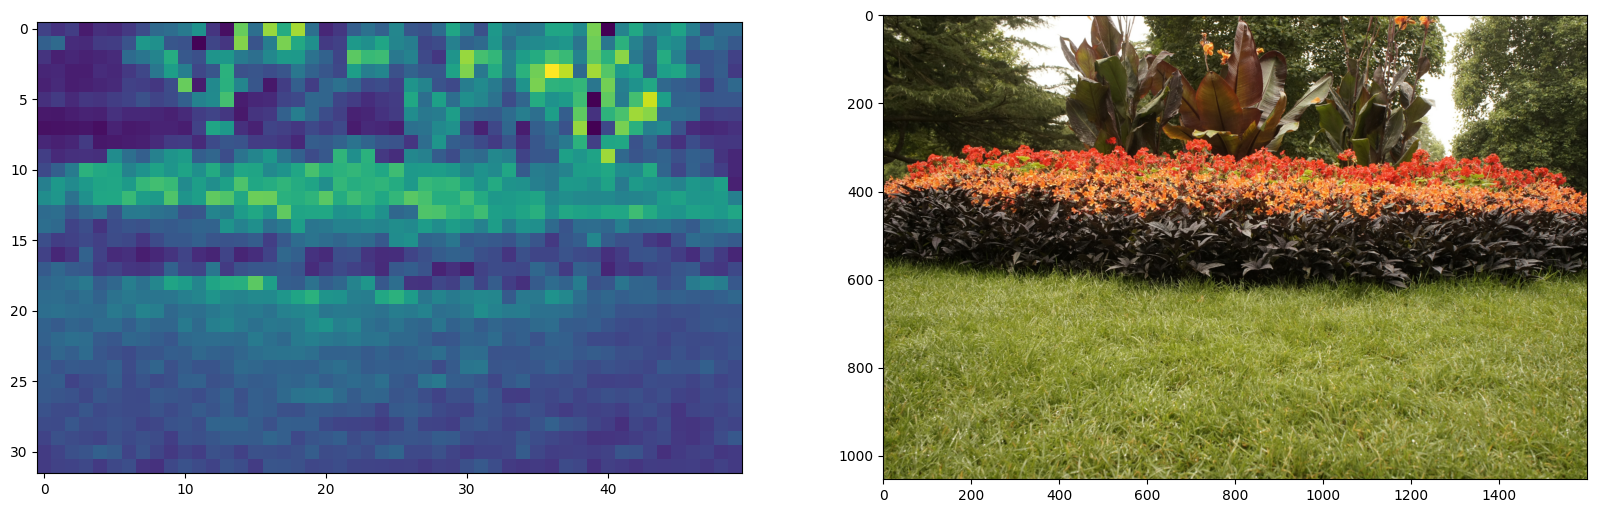

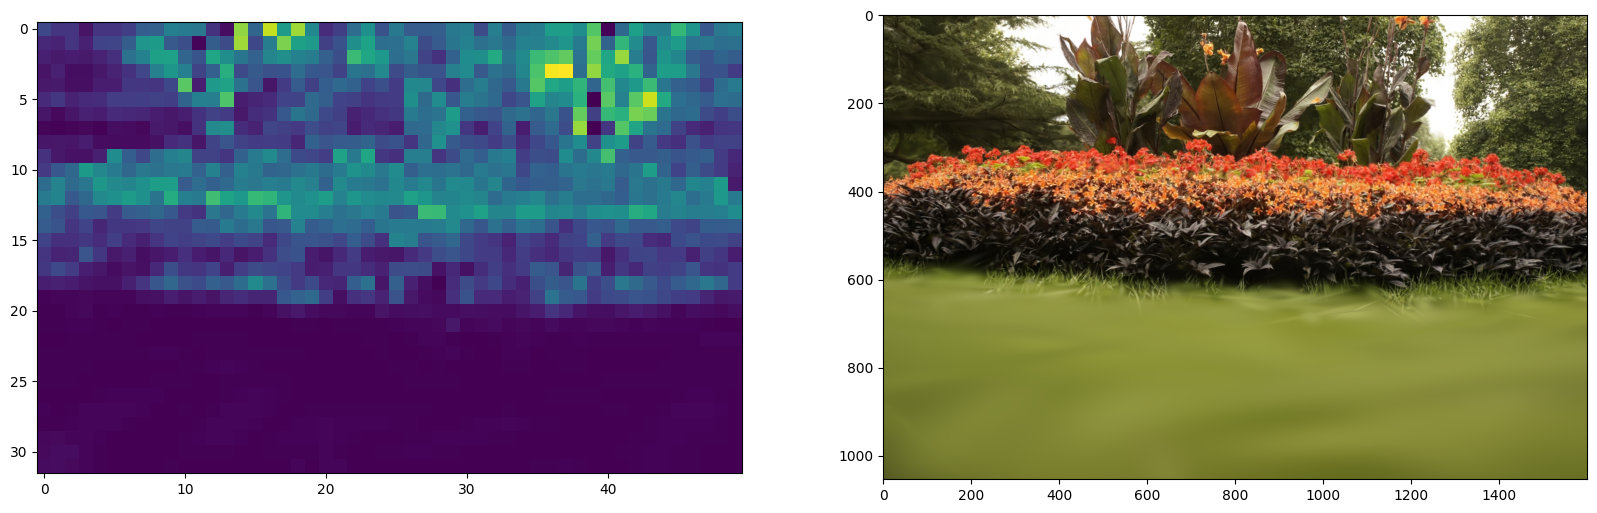

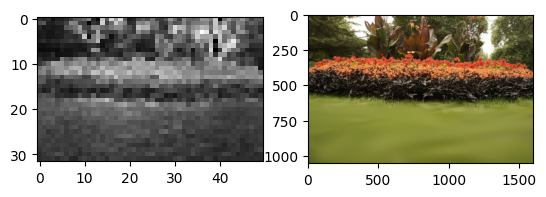

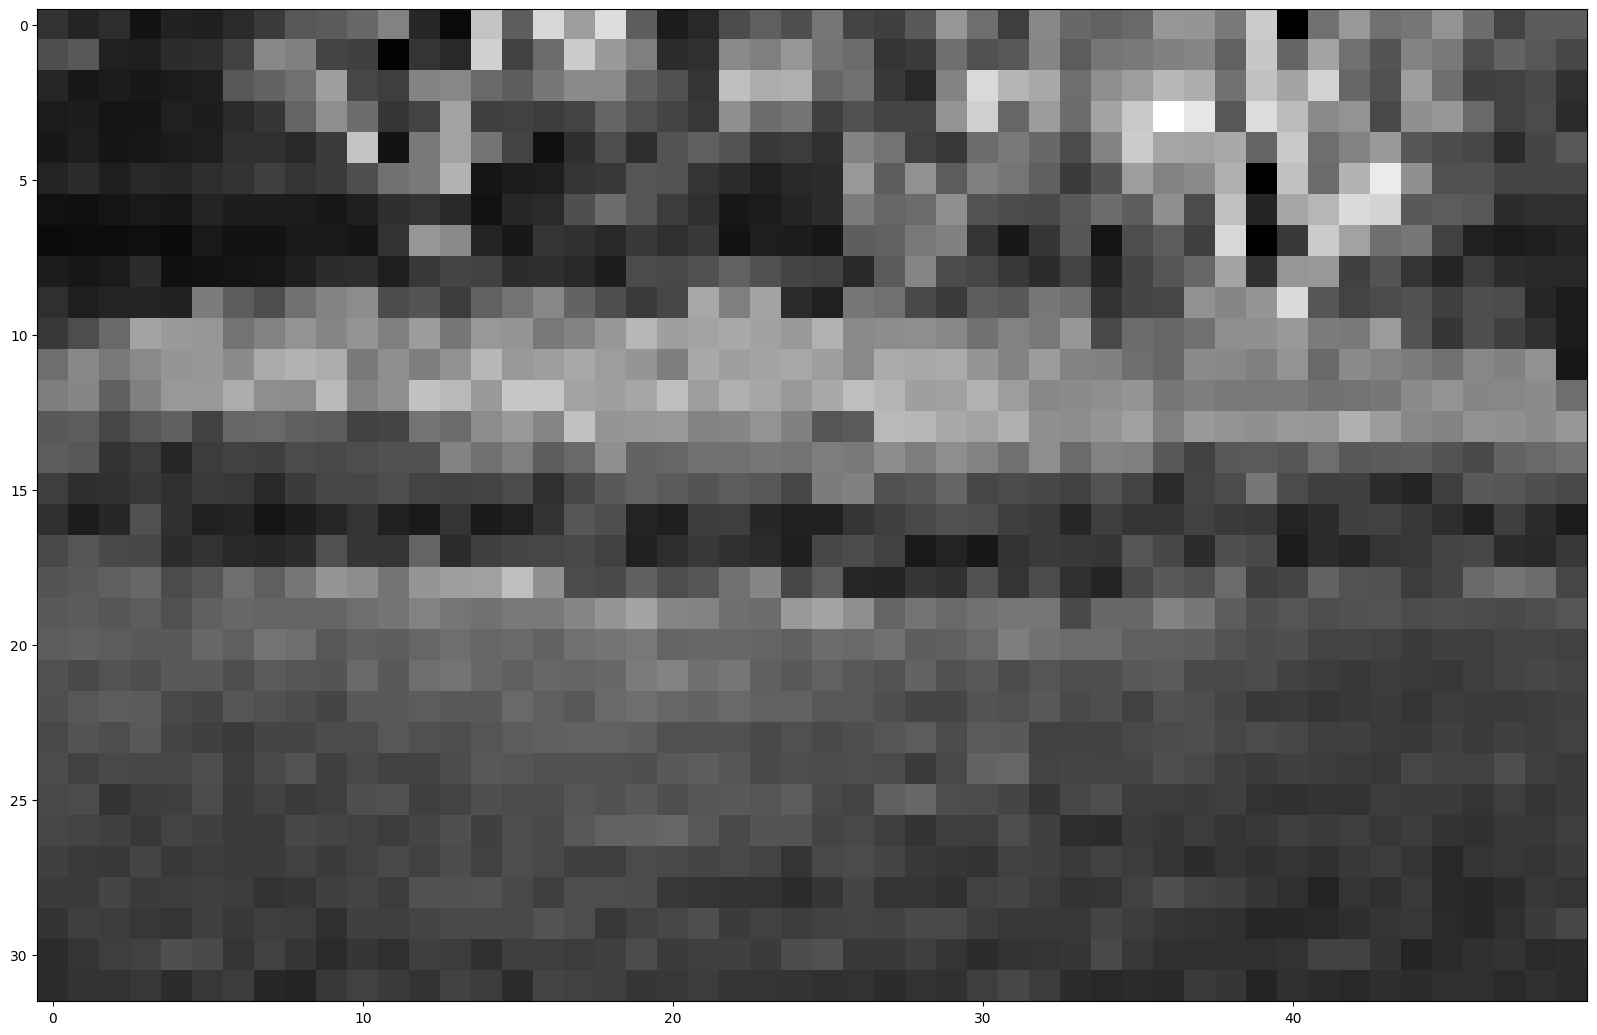

In [101]:
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(
    np.array(high_freq_score_gt).reshape(
        int(image_gt_np.shape[0]/patch_size[0]), int(image_gt_np.shape[1]/patch_size[1])
    )
)
plt.subplot(1,2,2)
plt.imshow(image_gt_np)

plt.show()

plt.figure(figsize=(20, 20))
fig = plt.subplot(1,2,1)

plt.imshow(
    np.array(high_freq_score_rendered).reshape(
        int(image_rendered_np.shape[0]/patch_size[0]), int(image_rendered_np.shape[1]/patch_size[1])
    )
)
plt.subplot(1,2,2)
plt.imshow(image_rendered_np)
plt.show()


plt.subplot(1,2,1)
plt.imshow(
    np.array(high_freq_score_diff).reshape(
        int(image_rendered_np.shape[0]/patch_size[0]), int(image_rendered_np.shape[1]/patch_size[1])
    ),
    cmap="gray"
)
plt.subplot(1,2,2)
plt.imshow(image_rendered_np)
plt.show()

plt.figure(figsize=(20, 20))
plt.imshow(
    np.abs(
        np.array(high_freq_score_gt).reshape(
            int(image_gt_np.shape[0]/patch_size[0]), int(image_gt_np.shape[1]/patch_size[1])
        ) - np.array(high_freq_score_rendered).reshape(
            int(image_rendered_np.shape[0]/patch_size[0]), int(image_rendered_np.shape[1]/patch_size[1])
        )
    ), cmap = "gray"
)